In [65]:
import numpy as np
import matplotlib.pyplot as plt

In [66]:
class Redditor:
    def __init__(self, susceptibility, capital):
        self.s = susceptibility
        self.c = capital
        self.conviction = 0
        self.invested = 0
        self.buy_price = 0
        
    def convince(self, sentiment):
        if self.conviction == 0 and sentiment < 0:
            self.conviction = 0
        else:
            self.conviction += self.s*sentiment
        
    def buy_or_sell(self, price, diamond_hands, bought_in, buy_counter, sell_counter):
        
        #Bought In:
        if self.conviction > bought_in and self.conviction < diamond_hands:
            self.invested = self.c/20
            buy_counter += self.c/20
            self.c -= self.c/20
            self.buy_price = price
            
        if self.invested > 0:
            if price > 1.5*self.buy_price:
                self.c += 1.5*self.invested
                sell_counter += 1.5*self.invested
                self.invested = 0
                        
            elif price < 0.5*self.buy_price:
                self.c += 0.5*self.invested
                sell_counter += 0.5*self.invested
                self.invested = 0 
                    
        #Diamond Hands:
        if self.conviction >= diamond_hands:
            self.invested += self.c
            buy_counter += self.c
            self.c = 0
            self.buy_price = price

        #Unconvinced: 
        if self.conviction <= bought_in and self.invested > 0:
            if price > 1.1*self.buy_price:
                self.invested = 0
                sell_counter += 1.1*self.invested
                self.c += 1.1*self.invested
            elif price < 0.9*self.buy_price:
                self.invested = 0
                sell_counter += 0.9*self.invested
                self.c -= 0.1*self.invested
            
        return buy_counter, sell_counter
    
    
class Shorter:
    def __init__(self, susceptibility, short_duration, capital):
        self.s = susceptibility
        self.c = capital
        self.short_duration = short_duration
        self.invested = 0
        self.short_time = 0
        self.short_price = 0
        self.shorted = False
        
    def decide_short(self, price, short_interest, threshold, sell_counter):
        if self.shorted == False:
            if self.s*short_interest > threshold:
                self.invested = self.c
                sell_counter += self.c
                self.c = 0
                self.short_price = price
        return sell_counter 
            
    def short_counter(self, price, buy_counter):
        if self.short_time == self.short_duration:
            self.c += (price/self.short_price)*self.invested
            buy_counter += (price/self.short_price)*self.invested
            self.invested = 0
            self.short_time = 0
            self.shorted = True
        if self.invested > 0:
            self.short_time += 1
        
        return buy_counter
        
class Market:
    
    def __init__(self, initial_price):
        self.price = initial_price
        
    def update_price(self, buy_counter, sell_counter):
        self.price += 0.5*(buy_counter - sell_counter)

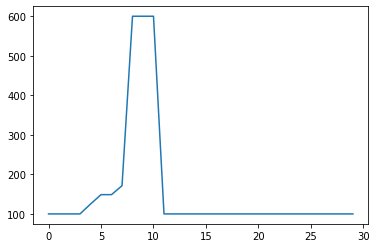

In [73]:
bought_in = 1
diamond_hands = 2
short_threshold = 1

initial_price = 100
buy_counter = 0
sell_counter = 0
redditor_count = 10
shorter_count = 1
short_interest = 0

n_days = 30

market = Market(initial_price)
redditors = [Redditor(1, 1000) for _ in range(redditor_count)]
shorters =[Shorter(1,10, 1000) for _ in range(shorter_count)]
prices = np.zeros(n_days)

for day in range(n_days):
    sentiment = np.random.uniform(-1, 1)
    short_interest += 0.1
    
    for redditor in redditors:
        buy = 0
        sell = 0
        redditor.convince(sentiment)
        buy, sell = redditor.buy_or_sell(market.price, diamond_hands, bought_in, buy, sell)
        buy_counter =+ buy
        sell_counter =+ sell
        
    for shorter in shorters:
        sell_counter =+ shorter.decide_short(market.price, short_interest, short_threshold, sell)
        buy_counter =+ shorter.short_counter(market.price, buy)

    prices[day] = market.price
    market.update_price(buy_counter, sell_counter)
    
plt.plot(prices);

In [1]:
import pandas as pd
sentiment_values = pd.read_csv('redditpostsRevelant.csv')
sentiment_values = sentiment_values[['created_utc', 'text_sentiment_score']]
sentiment_values['created_utc'] = pd.to_datetime(sentiment_values['created_utc'])

In [2]:
sentiment_values = sentiment_values.rename({'created_utc':'ds'}, axis='columns')
sentiment_values = sentiment_values.set_index('ds')
sentiment_values.sort_index(inplace=True)
sentiment_values

,text_sentiment_score
ds,
2020-09-01 05:08:28,0.0000
2020-09-01 17:58:20,0.0000
2020-09-01 18:08:27,0.0000
2020-09-02 13:39:37,0.0000
2020-09-03 03:00:13,0.0000
...,...
2021-06-24 12:53:46,0.0000
2021-06-24 13:11:48,0.8544
2021-06-24 14:27:09,0.2960


In [3]:
#Resample so the interval is one day, take data as is.
sentiment_values = sentiment_values[['text_sentiment_score']].resample('D').sum()
sentiment_values

,text_sentiment_score
ds,
2020-09-01,0.0000
2020-09-02,0.0000
2020-09-03,0.2732
2020-09-04,0.0000
2020-09-05,0.0000
...,...
2021-06-20,0.7067
2021-06-21,5.7012
2021-06-22,7.5271
